## Environment set up

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Dropout,LSTM
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import csv
import os
import tabulate
from sklearn.preprocessing import LabelEncoder
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix, roc_curve
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
get_ipython().magic('matplotlib inline')

In [54]:
import datetime as dt
from scipy import stats
from scipy.stats import norm
import seaborn as sns

In [43]:
# Reading and showing head data
flights = pd.read_csv("619804640_T_ONTIME_MARKETING.csv")
flights.head()

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,...,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 30
0,2020,1,1,3,WN,N951WN,ONT,SFO,1810,1851.0,...,122.0,74.0,1.0,363.0,8.0,0.0,27.0,0.0,33.0,NaN
1,2020,1,1,3,WN,N467WN,ONT,SFO,1150,1146.0,...,92.0,71.0,1.0,363.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2020,1,1,3,WN,N7885A,ONT,SJC,2020,2016.0,...,68.0,57.0,1.0,333.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2020,1,1,3,WN,N551WN,ONT,SJC,1340,1350.0,...,75.0,63.0,1.0,333.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2020,1,1,3,WN,N968WN,ONT,SJC,915,916.0,...,67.0,57.0,1.0,333.0,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660556 entries, 0 to 660555
Data columns (total 31 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   YEAR                 660556 non-null  int64  
 1   MONTH                660556 non-null  int64  
 2   DAY_OF_MONTH         660556 non-null  int64  
 3   DAY_OF_WEEK          660556 non-null  int64  
 4   OP_UNIQUE_CARRIER    660556 non-null  object 
 5   TAIL_NUM             659057 non-null  object 
 6   ORIGIN               660556 non-null  object 
 7   DEST                 660556 non-null  object 
 8   CRS_DEP_TIME         660556 non-null  int64  
 9   DEP_TIME             652478 non-null  float64
 10  DEP_DELAY            652443 non-null  float64
 11  TAXI_OUT             652286 non-null  float64
 12  TAXI_IN              651949 non-null  float64
 13  CRS_ARR_TIME         660556 non-null  int64  
 14  ARR_TIME             651949 non-null  float64
 15  ARR_DELAY        

## Data Wrangling

Target variable is 'ArrDel15' and there was substantial class imbalances as seen below. In order to avoid the classifier learning one class better than the other, sampling was done to even out the class imbalance.

In [16]:
#Handles class imbalance through sampling
classDistribution = flights['ARR_DEL15'].value_counts()
print('Class imbalance:')
print(classDistribution)
zero = flights[flights['ARR_DEL15']==0].tail(classDistribution.min())
one = flights[flights['ARR_DEL15']==1]
data = zero.append(one)
del zero, one
data.sort_values(['YEAR','MONTH','DAY_OF_MONTH','DAY_OF_WEEK'], ascending=[False,False,False,False])
#del fdata
print('Class imbalance evened out:')
print(data['ARR_DEL15'].value_counts())
len(data.columns)

Class imbalance:
0.0    558686
1.0     92164
Name: ARR_DEL15, dtype: int64
Class imbalance evened out:
1.0    92164
0.0    92164
Name: ARR_DEL15, dtype: int64


31

In [17]:
data.shape

(184328, 31)

In [20]:
data.dtypes

YEAR                     int64
MONTH                    int64
DAY_OF_MONTH             int64
DAY_OF_WEEK              int64
OP_UNIQUE_CARRIER       object
TAIL_NUM                object
ORIGIN                  object
DEST                    object
CRS_DEP_TIME             int64
DEP_TIME               float64
DEP_DELAY              float64
TAXI_OUT               float64
TAXI_IN                float64
CRS_ARR_TIME             int64
ARR_TIME               float64
ARR_DELAY              float64
ARR_DEL15              float64
CANCELLED              float64
CANCELLATION_CODE       object
DIVERTED               float64
CRS_ELAPSED_TIME       float64
ACTUAL_ELAPSED_TIME    float64
AIR_TIME               float64
FLIGHTS                float64
DISTANCE               float64
CARRIER_DELAY          float64
WEATHER_DELAY          float64
NAS_DELAY              float64
SECURITY_DELAY         float64
LATE_AIRCRAFT_DELAY    float64
Unnamed: 30            float64
dtype: object

In [23]:
data = data.iloc[:,0:31]#Removing sparse columns based on the information given in DOT website
print('Dimension reduced to:')
len(data.columns)

Dimension reduced to:


31

In [24]:
data.shape

(184328, 31)

In [25]:
print('Dimension reduced to:')
print(len(data.columns))
print('Sparsity per variable:')
((len(data.index) - data.count())/len(data.index))#Sparsity per variable retained

Dimension reduced to:
31
Sparsity per variable:


YEAR                   0.0
MONTH                  0.0
DAY_OF_MONTH           0.0
DAY_OF_WEEK            0.0
OP_UNIQUE_CARRIER      0.0
TAIL_NUM               0.0
ORIGIN                 0.0
DEST                   0.0
CRS_DEP_TIME           0.0
DEP_TIME               0.0
DEP_DELAY              0.0
TAXI_OUT               0.0
TAXI_IN                0.0
CRS_ARR_TIME           0.0
ARR_TIME               0.0
ARR_DELAY              0.0
ARR_DEL15              0.0
CANCELLED              0.0
CANCELLATION_CODE      1.0
DIVERTED               0.0
CRS_ELAPSED_TIME       0.0
ACTUAL_ELAPSED_TIME    0.0
AIR_TIME               0.0
FLIGHTS                0.0
DISTANCE               0.0
CARRIER_DELAY          0.5
WEATHER_DELAY          0.5
NAS_DELAY              0.5
SECURITY_DELAY         0.5
LATE_AIRCRAFT_DELAY    0.5
Unnamed: 30            1.0
dtype: float64

In [26]:
data.drop(['Unnamed: 30'],
          axis=1, inplace=True)#Removed due to garbage
data.drop(['CANCELLATION_CODE'], axis=1, inplace=True)#Removed due to 100% sparsity as seen in above cell

In [27]:
data['DepDate'] = pd.to_datetime(data.YEAR*10000+data.MONTH*100+data.DAY_OF_MONTH,format='%Y%m%d')

In [28]:
print('Dimension reduced to:')
print(len(data.columns))
print('Sparsity per variable:')
((len(data.index) - data.count())/len(data.index))#Sparsity per variable retained

Dimension reduced to:
30
Sparsity per variable:


YEAR                   0.0
MONTH                  0.0
DAY_OF_MONTH           0.0
DAY_OF_WEEK            0.0
OP_UNIQUE_CARRIER      0.0
TAIL_NUM               0.0
ORIGIN                 0.0
DEST                   0.0
CRS_DEP_TIME           0.0
DEP_TIME               0.0
DEP_DELAY              0.0
TAXI_OUT               0.0
TAXI_IN                0.0
CRS_ARR_TIME           0.0
ARR_TIME               0.0
ARR_DELAY              0.0
ARR_DEL15              0.0
CANCELLED              0.0
DIVERTED               0.0
CRS_ELAPSED_TIME       0.0
ACTUAL_ELAPSED_TIME    0.0
AIR_TIME               0.0
FLIGHTS                0.0
DISTANCE               0.0
CARRIER_DELAY          0.5
WEATHER_DELAY          0.5
NAS_DELAY              0.5
SECURITY_DELAY         0.5
LATE_AIRCRAFT_DELAY    0.5
DepDate                0.0
dtype: float64

In [29]:
def showtable(df):
    '''
    Returns few key metrics of a dataframe.
    '''
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

In [35]:
type(data)

pandas.core.frame.DataFrame

In [36]:
type(flights)

pandas.core.frame.DataFrame

In [45]:
showtable(flights)

Dataset Shape: (660556, 31)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,YEAR,int64,0,1,2020,2020,2020,0.00
1,MONTH,int64,0,1,1,1,1,0.00
2,DAY_OF_MONTH,int64,0,31,1,1,1,4.95
3,DAY_OF_WEEK,int64,0,7,3,3,3,2.79
4,OP_UNIQUE_CARRIER,object,0,25,WN,WN,WN,3.99
5,TAIL_NUM,object,1499,5802,N951WN,N467WN,N7885A,12.34
6,ORIGIN,object,0,365,ONT,ONT,ONT,6.61
7,DEST,object,0,365,SFO,SFO,SJC,6.61
8,CRS_DEP_TIME,int64,0,1242,1810,1150,2020,9.20
9,DEP_TIME,float64,8078,1432,1851,1146,2016,10.08


In [49]:
df = flights

In [47]:
df = df.drop(['Unnamed: 30','LATE_AIRCRAFT_DELAY','SECURITY_DELAY','NAS_DELAY','WEATHER_DELAY','CARRIER_DELAY',
                  'CANCELLATION_CODE',],
          axis=1, inplace=True)#Removed due to about 90% nan values

In [58]:
df['DepDate'] = pd.to_datetime(df.YEAR*10000+df.MONTH*100+df.DAY_OF_MONTH,format='%Y%m%d')

In [59]:
showtable(df)

Dataset Shape: (660556, 25)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,YEAR,int64,0,1,2020,2020,2020,0.00
1,MONTH,int64,0,1,1,1,1,0.00
2,DAY_OF_MONTH,int64,0,31,1,1,1,4.95
3,DAY_OF_WEEK,int64,0,7,3,3,3,2.79
4,OP_UNIQUE_CARRIER,object,0,25,WN,WN,WN,3.99
5,TAIL_NUM,object,1499,5802,N951WN,N467WN,N7885A,12.34
6,ORIGIN,object,0,365,ONT,ONT,ONT,6.61
7,DEST,object,0,365,SFO,SFO,SJC,6.61
8,CRS_DEP_TIME,int64,0,1242,1810,1150,2020,9.20
9,DEP_TIME,float64,8078,1432,1851,1146,2016,10.08


In [60]:
print ("Rows           =",df.shape[0])
print ("Columns        =",df.shape[1])
print ("\nFeatures       =\n  ",df.columns.to_list())
print ("\nNull Vlaues    =",df.isnull().sum().values.sum())
print ("\nunique Vlaues  =\n",df.nunique())

Rows           = 660556
Columns        = 25

Features       =
   ['YEAR', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER', 'TAIL_NUM', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'ARR_DEL15', 'CANCELLED', 'DIVERTED', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'FLIGHTS', 'DISTANCE', 'DepDate']

Null Vlaues    = 81998

unique Vlaues  =
 YEAR                      1
MONTH                     1
DAY_OF_MONTH             31
DAY_OF_WEEK               7
OP_UNIQUE_CARRIER        25
TAIL_NUM               5802
ORIGIN                  365
DEST                    365
CRS_DEP_TIME           1242
DEP_TIME               1432
DEP_DELAY              1042
TAXI_OUT                158
TAXI_IN                 107
CRS_ARR_TIME           1329
ARR_TIME               1440
ARR_DELAY              1060
ARR_DEL15                 2
CANCELLED                 2
DIVERTED                  2
CRS_ELAPSED_TIME        467


In [67]:
df["ARR_DEL15"] = df["ARR_DEL15"].replace("NaN",np.nan)

In [68]:
df = df[df["ARR_DEL15"].notnull()]
df = df.reset_index()[df.columns]

In [69]:
showtable(df)

Dataset Shape: (650850, 25)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,YEAR,int64,0,1,2020,2020,2020,0.00
1,MONTH,int64,0,1,1,1,1,0.00
2,DAY_OF_MONTH,int64,0,31,1,1,1,4.95
3,DAY_OF_WEEK,int64,0,7,3,3,3,2.79
4,OP_UNIQUE_CARRIER,object,0,25,WN,WN,WN,3.99
5,TAIL_NUM,object,0,5801,N951WN,N467WN,N7885A,12.34
6,ORIGIN,object,0,365,ONT,ONT,ONT,6.60
7,DEST,object,0,365,SFO,SFO,SJC,6.60
8,CRS_DEP_TIME,int64,0,1242,1810,1150,2020,9.20
9,DEP_TIME,float64,0,1432,1851,1146,2016,10.08


In [70]:
print ("Rows           =",df.shape[0])
print ("Columns        =",df.shape[1])
print ("\nFeatures       =\n  ",df.columns.to_list())
print ("\nNull Vlaues    =",df.isnull().sum().values.sum())
print ("\nunique Vlaues  =\n",df.nunique())

Rows           = 650850
Columns        = 25

Features       =
   ['YEAR', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER', 'TAIL_NUM', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'ARR_DEL15', 'CANCELLED', 'DIVERTED', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'FLIGHTS', 'DISTANCE', 'DepDate']

Null Vlaues    = 0

unique Vlaues  =
 YEAR                      1
MONTH                     1
DAY_OF_MONTH             31
DAY_OF_WEEK               7
OP_UNIQUE_CARRIER        25
TAIL_NUM               5801
ORIGIN                  365
DEST                    365
CRS_DEP_TIME           1242
DEP_TIME               1432
DEP_DELAY              1030
TAXI_OUT                157
TAXI_IN                 107
CRS_ARR_TIME           1329
ARR_TIME               1440
ARR_DELAY              1060
ARR_DEL15                 2
CANCELLED                 1
DIVERTED                  1
CRS_ELAPSED_TIME        467
ACTU

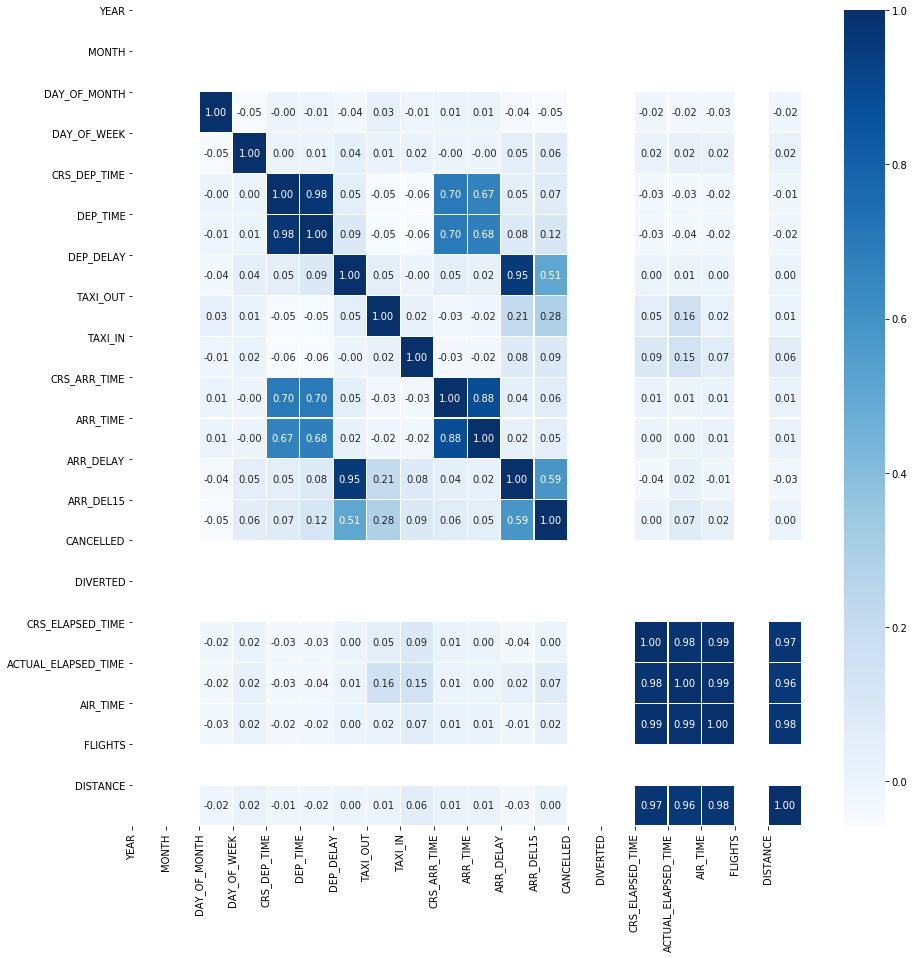

In [71]:
def heatmap(data):
    corr = data.corr()
    fig,ax = plt.subplots(figsize=(15,15))
    sns.heatmap(corr,cmap="Blues",annot=True,fmt=".2f",linewidths=.2)
    plt.xticks(range(len(corr.columns)),corr.columns)
    plt.yticks(range(len(corr.columns)),corr.columns)
    plt.show
heatmap(df)

In [72]:
corr_feat = df[df.columns[0:]].corr()["ARR_DEL15"][:]

In [73]:
np.abs(corr_feat).sort_values(ascending=False)[1:]

ARR_DELAY              0.585749
DEP_DELAY              0.511011
TAXI_OUT               0.283932
DEP_TIME               0.119047
TAXI_IN                0.092926
CRS_DEP_TIME           0.069676
ACTUAL_ELAPSED_TIME    0.067676
CRS_ARR_TIME           0.062378
DAY_OF_WEEK            0.055475
ARR_TIME               0.052614
DAY_OF_MONTH           0.049943
AIR_TIME               0.021501
CRS_ELAPSED_TIME       0.003397
DISTANCE               0.001488
YEAR                        NaN
MONTH                       NaN
CANCELLED                   NaN
DIVERTED                    NaN
FLIGHTS                     NaN
Name: ARR_DEL15, dtype: float64

In [74]:
## Drop unwanted colmuns
df = df.drop("YEAR",1) 
df = df.drop("DAY_OF_MONTH",1) 
df = df.drop("MONTH",1) 
df = df.drop("FLIGHTS",1) 
df = df.drop("CANCELLED",1) 

In [76]:
corr_feat = df[df.columns[0:]].corr()["ARR_DEL15"][:]
np.abs(corr_feat).sort_values(ascending=False)[1:]

ARR_DELAY              0.585749
DEP_DELAY              0.511011
TAXI_OUT               0.283932
DEP_TIME               0.119047
TAXI_IN                0.092926
CRS_DEP_TIME           0.069676
ACTUAL_ELAPSED_TIME    0.067676
CRS_ARR_TIME           0.062378
DAY_OF_WEEK            0.055475
ARR_TIME               0.052614
AIR_TIME               0.021501
CRS_ELAPSED_TIME       0.003397
DISTANCE               0.001488
DIVERTED                    NaN
Name: ARR_DEL15, dtype: float64

In [77]:
df = df.drop("DIVERTED",1) 

In [78]:
corr_feat = df[df.columns[0:]].corr()["ARR_DEL15"][:]
np.abs(corr_feat).sort_values(ascending=False)[1:]

ARR_DELAY              0.585749
DEP_DELAY              0.511011
TAXI_OUT               0.283932
DEP_TIME               0.119047
TAXI_IN                0.092926
CRS_DEP_TIME           0.069676
ACTUAL_ELAPSED_TIME    0.067676
CRS_ARR_TIME           0.062378
DAY_OF_WEEK            0.055475
ARR_TIME               0.052614
AIR_TIME               0.021501
CRS_ELAPSED_TIME       0.003397
DISTANCE               0.001488
Name: ARR_DEL15, dtype: float64

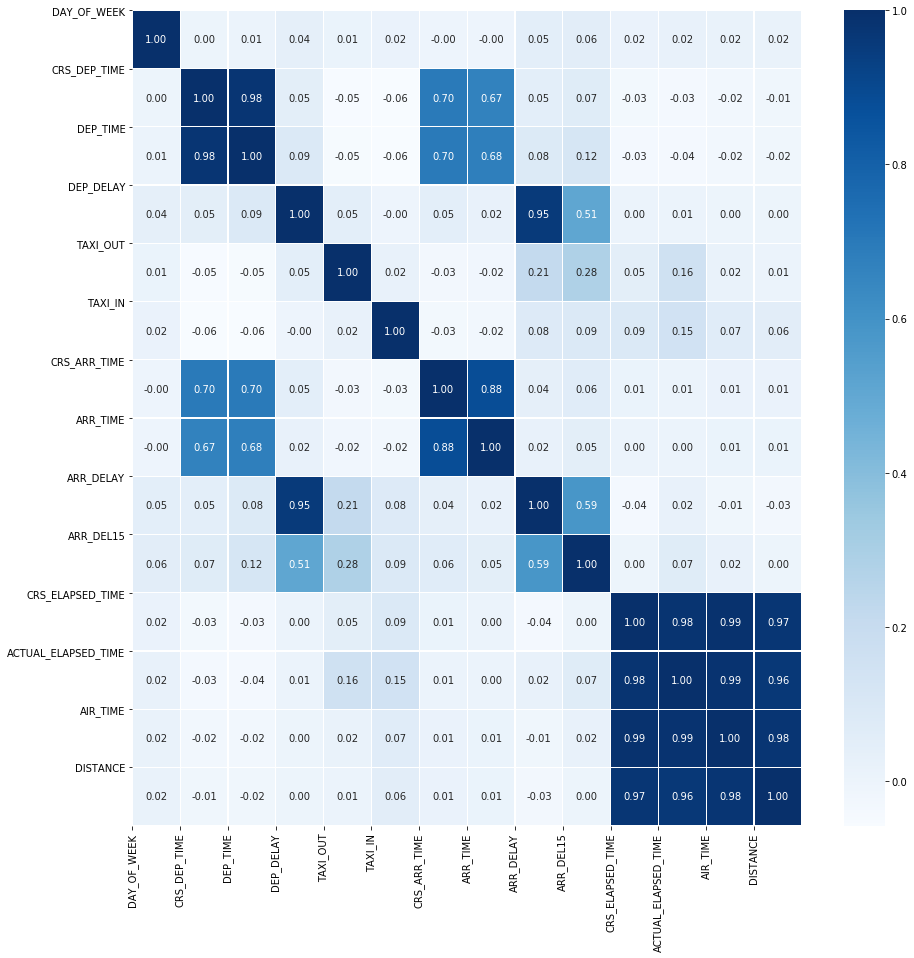

In [79]:
heatmap(df)

In [80]:
showtable(df)

Dataset Shape: (650850, 19)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,DAY_OF_WEEK,int64,0,7,3,3,3,2.79
1,OP_UNIQUE_CARRIER,object,0,25,WN,WN,WN,3.99
2,TAIL_NUM,object,0,5801,N951WN,N467WN,N7885A,12.34
3,ORIGIN,object,0,365,ONT,ONT,ONT,6.60
4,DEST,object,0,365,SFO,SFO,SJC,6.60
5,CRS_DEP_TIME,int64,0,1242,1810,1150,2020,9.20
6,DEP_TIME,float64,0,1432,1851,1146,2016,10.08
7,DEP_DELAY,float64,0,1030,41,-4,-4,5.33
8,TAXI_OUT,float64,0,157,44,13,8,4.86
9,TAXI_IN,float64,0,107,4,8,3,3.90


In [81]:
df.dtypes

DAY_OF_WEEK                     int64
OP_UNIQUE_CARRIER              object
TAIL_NUM                       object
ORIGIN                         object
DEST                           object
CRS_DEP_TIME                    int64
DEP_TIME                      float64
DEP_DELAY                     float64
TAXI_OUT                      float64
TAXI_IN                       float64
CRS_ARR_TIME                    int64
ARR_TIME                      float64
ARR_DELAY                     float64
ARR_DEL15                     float64
CRS_ELAPSED_TIME              float64
ACTUAL_ELAPSED_TIME           float64
AIR_TIME                      float64
DISTANCE                      float64
DepDate                datetime64[ns]
dtype: object

### Exploratory Analysis

<Figure size 1080x360 with 0 Axes>

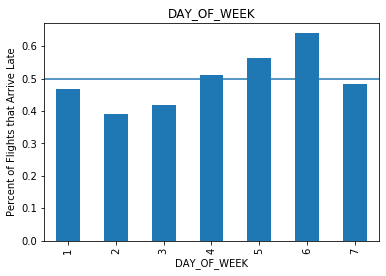

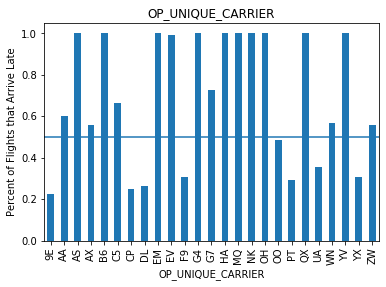

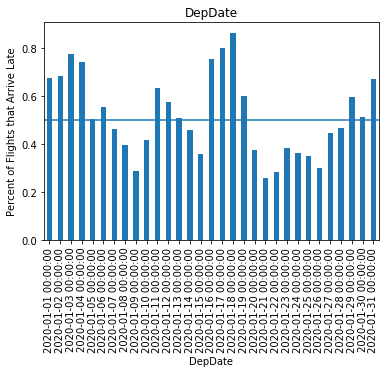

In [84]:
# Proportion of late flights per category based on all other flights

avgLate = np.sum(data['ARR_DEL15'])/len(data['ARR_DEL15'])
attributes = ['DAY_OF_WEEK','OP_UNIQUE_CARRIER',"DepDate"]
for i,pred in enumerate(attributes):
    plt.figure(i, figsize=(15, 5))
    group = data.groupby([pred], as_index=False).aggregate(np.mean)[[pred, 'ARR_DEL15']]
    group.sort_values(by=pred, inplace=True)    
    group.plot.bar(x=pred, y='ARR_DEL15')
    plt.axhline(y=avgLate, label='Average')
    plt.ylabel('Percent of Flights that Arrive Late')
    plt.title(pred)
    plt.legend().remove()

In [85]:
df = df.drop("DEST",1) 
df = df.drop("TAIL_NUM",1) 
df = df.drop("ORIGIN",1) 

In [86]:
df.dtypes

DAY_OF_WEEK                     int64
OP_UNIQUE_CARRIER              object
CRS_DEP_TIME                    int64
DEP_TIME                      float64
DEP_DELAY                     float64
TAXI_OUT                      float64
TAXI_IN                       float64
CRS_ARR_TIME                    int64
ARR_TIME                      float64
ARR_DELAY                     float64
ARR_DEL15                     float64
CRS_ELAPSED_TIME              float64
ACTUAL_ELAPSED_TIME           float64
AIR_TIME                      float64
DISTANCE                      float64
DepDate                datetime64[ns]
dtype: object

In [87]:
corr_feat = df[df.columns[0:]].corr()["ARR_DEL15"][:]
np.abs(corr_feat).sort_values(ascending=False)[1:]

ARR_DELAY              0.585749
DEP_DELAY              0.511011
TAXI_OUT               0.283932
DEP_TIME               0.119047
TAXI_IN                0.092926
CRS_DEP_TIME           0.069676
ACTUAL_ELAPSED_TIME    0.067676
CRS_ARR_TIME           0.062378
DAY_OF_WEEK            0.055475
ARR_TIME               0.052614
AIR_TIME               0.021501
CRS_ELAPSED_TIME       0.003397
DISTANCE               0.001488
Name: ARR_DEL15, dtype: float64

In [88]:
print('Dimension reduced to:')
print(len(df.columns))
df.describe()

Dimension reduced to:
16


,DAY_OF_WEEK,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DEL15,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE
count,650850.000000,650850.000000,650850.000000,650850.000000,650850.000000,650850.000000,650850.000000,650850.000000,650850.000000,650850.000000,650850.000000,650850.000000,650850.000000,650850.000000
mean,3.945745,1329.474334,1332.090820,6.279511,17.566697,7.558565,1491.328755,1477.223583,-1.195899,0.141606,141.154346,133.679156,108.553894,767.657502
std,1.911751,486.241257,494.639089,43.345615,9.793850,5.757928,513.435521,522.317476,45.615262,0.348645,71.701908,71.112048,69.611380,580.199791
min,1.000000,2.000000,1.000000,-58.000000,0.000000,0.000000,1.000000,1.000000,-96.000000,0.000000,-77.000000,15.000000,8.000000,31.000000
25%,2.000000,920.000000,921.000000,-6.000000,11.000000,4.000000,1109.000000,1059.000000,-18.000000,0.000000,90.000000,82.000000,58.000000,343.000000
50%,4.000000,1323.000000,1327.000000,-3.000000,15.000000,6.000000,1518.000000,1511.000000,-10.000000,0.000000,123.000000,116.000000,90.000000,606.000000
75%,5.000000,1730.000000,1738.000000,2.000000,21.000000,9.000000,1919.000000,1915.000000,2.000000,0.000000,171.000000,164.000000,138.000000,1009.000000
max,7.000000,2359.000000,2400.000000,2489.000000,189.000000,146.000000,2400.000000,2400.000000,2536.000000,1.000000,700.000000,744.000000,698.000000,5095.000000


In [91]:
df.head()

,DAY_OF_WEEK,OP_UNIQUE_CARRIER,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DEL15,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,DepDate
0,3,WN,1810,1851.0,41.0,44.0,4.0,1945,2053.0,68.0,1.0,95.0,122.0,74.0,363.0,2020-01-01
1,3,WN,1150,1146.0,-4.0,13.0,8.0,1320,1318.0,-2.0,0.0,90.0,92.0,71.0,363.0,2020-01-01
2,3,WN,2020,2016.0,-4.0,8.0,3.0,2130,2124.0,-6.0,0.0,70.0,68.0,57.0,333.0,2020-01-01
3,3,WN,1340,1350.0,10.0,10.0,2.0,1455,1505.0,10.0,0.0,75.0,75.0,63.0,333.0,2020-01-01
4,3,WN,915,916.0,1.0,6.0,4.0,1035,1023.0,-12.0,0.0,80.0,67.0,57.0,333.0,2020-01-01


In [89]:
df["ARR_DEL15"].unique()

array([1., 0.])

#### Label encoding:
Conversion of categorical values to numericals

In [92]:
le = LabelEncoder()

df["OP_UNIQUE_CARRIER"] = le.fit_transform(df["OP_UNIQUE_CARRIER"])
UniqueCarrier = list(le.classes_)

In [93]:
df.head()

,DAY_OF_WEEK,OP_UNIQUE_CARRIER,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DEL15,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,DepDate
0,3,21,1810,1851.0,41.0,44.0,4.0,1945,2053.0,68.0,1.0,95.0,122.0,74.0,363.0,2020-01-01
1,3,21,1150,1146.0,-4.0,13.0,8.0,1320,1318.0,-2.0,0.0,90.0,92.0,71.0,363.0,2020-01-01
2,3,21,2020,2016.0,-4.0,8.0,3.0,2130,2124.0,-6.0,0.0,70.0,68.0,57.0,333.0,2020-01-01
3,3,21,1340,1350.0,10.0,10.0,2.0,1455,1505.0,10.0,0.0,75.0,75.0,63.0,333.0,2020-01-01
4,3,21,915,916.0,1.0,6.0,4.0,1035,1023.0,-12.0,0.0,80.0,67.0,57.0,333.0,2020-01-01


All variables are now numeric. But above statistics makes sense only for originally numeric variables. 

after cleaning the data save it 

In [94]:
df.to_csv('flight_2020_RNN.csv', index=False)

In [95]:
data = pd.read_csv('flight_2020_RNN.csv')

In [96]:
data.head()

,DAY_OF_WEEK,OP_UNIQUE_CARRIER,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DEL15,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,DepDate
0,3,21,1810,1851.0,41.0,44.0,4.0,1945,2053.0,68.0,1.0,95.0,122.0,74.0,363.0,2020-01-01
1,3,21,1150,1146.0,-4.0,13.0,8.0,1320,1318.0,-2.0,0.0,90.0,92.0,71.0,363.0,2020-01-01
2,3,21,2020,2016.0,-4.0,8.0,3.0,2130,2124.0,-6.0,0.0,70.0,68.0,57.0,333.0,2020-01-01
3,3,21,1340,1350.0,10.0,10.0,2.0,1455,1505.0,10.0,0.0,75.0,75.0,63.0,333.0,2020-01-01
4,3,21,915,916.0,1.0,6.0,4.0,1035,1023.0,-12.0,0.0,80.0,67.0,57.0,333.0,2020-01-01


## RNN Model

In [97]:
target = data["ARR_DEL15"]

In [99]:
data = data.drop("ARR_DEL15",1) 


In [131]:
data = data.drop("DepDate",1)

In [100]:
## X_train_arr = np.reshape(X_train.values,(X_train.values.shape[0],1,X_train.values.shape[1]))

In [132]:
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=93)

In [133]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(520680, 14)
(520680,)
(130170, 14)
(130170,)


In [134]:
y_train.shape[0]

520680

In [135]:
x_train_arr = np.reshape(x_train.values,(x_train.values.shape[0],1,x_train.values.shape[1]))
y_train_arr = np.array(y_train).reshape(y_train.shape[0], 1)
x_test_arr = np.reshape(x_test.values,(x_test.values.shape[0],1,x_test.values.shape[1]))
y_test_arr = np.array(y_test).reshape(y_test.shape[0], 1)

In [136]:
print('x_train_arr = ',x_train_arr.shape)
print('y_train_arr = ',y_train_arr.shape)
print('x_test_arr  = ',x_test_arr.shape)
print('y_test_arr =  ',y_test_arr.shape)

x_train_arr =  (520680, 1, 14)
y_train_arr =  (520680, 1)
x_test_arr  =  (130170, 1, 14)
y_test_arr =   (130170, 1)


In [137]:
print('x_train_arr = ',type(x_train_arr))
print('y_train_arr = ',type(y_train_arr))
print('x_test_arr  = ',type(x_test_arr))
print('y_test_arr =  ',type(y_test_arr))

x_train_arr =  <class 'numpy.ndarray'>
y_train_arr =  <class 'numpy.ndarray'>
x_test_arr  =  <class 'numpy.ndarray'>
y_test_arr =   <class 'numpy.ndarray'>


In [138]:
x_train_arr.shape[1]

1

In [139]:
x_train

,DAY_OF_WEEK,OP_UNIQUE_CARRIER,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE
347550,4,14,1825,1836.0,11.0,29.0,9.0,1943,2005.0,22.0,78.0,89.0,51.0,304.0
201328,5,16,1755,1908.0,73.0,18.0,3.0,1826,1933.0,67.0,91.0,85.0,64.0,350.0
502590,3,21,1645,1656.0,11.0,12.0,19.0,2145,2201.0,16.0,180.0,185.0,154.0,1246.0
360209,6,4,1513,1510.0,-3.0,14.0,4.0,1659,1644.0,-15.0,106.0,94.0,76.0,399.0
474459,2,21,1415,1415.0,0.0,11.0,3.0,1640,1623.0,-17.0,85.0,68.0,54.0,368.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384085,4,1,504,500.0,-4.0,15.0,6.0,644,623.0,-21.0,100.0,83.0,62.0,366.0
466529,4,21,1340,1334.0,-6.0,14.0,6.0,1630,1605.0,-25.0,170.0,151.0,131.0,1005.0
481487,4,21,1225,1244.0,19.0,8.0,5.0,1310,1313.0,3.0,165.0,149.0,136.0,986.0
275608,3,17,1735,1730.0,-5.0,27.0,10.0,1858,1844.0,-14.0,83.0,74.0,37.0,196.0


In [141]:
model= Sequential()

model.add(LSTM(units = 60, activation = 'relu', return_sequences = True, input_shape =(x_train_arr.shape[1],14) ))
model.add(Dropout(0.2))

model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

In [143]:
model.compile(optimizer='adam', loss = 'mean_squared_error')

In [145]:
history = model.fit(x_train_arr,y_train_arr,epochs=10, batch_size=32 ,validation_data=(x_test_arr, y_test_arr))

Train on 520680 samples, validate on 130170 samples
Epoch 1/10
520680/520680 [==============================] - 112s 216us/sample - loss: 0.0417 - val_loss: 0.0144
Epoch 2/10
520680/520680 [==============================] - 110s 212us/sample - loss: 0.0201 - val_loss: 0.0100
Epoch 3/10
520680/520680 [==============================] - 107s 206us/sample - loss: 0.0122 - val_loss: 0.0060
Epoch 4/10
520680/520680 [==============================] - 109s 209us/sample - loss: 0.0091 - val_loss: 0.0054
Epoch 5/10
520680/520680 [==============================] - 111s 213us/sample - loss: 0.0086 - val_loss: 0.0024
Epoch 6/10
520680/520680 [==============================] - 111s 213us/sample - loss: 0.0080 - val_loss: 0.0098
Epoch 7/10
520680/520680 [==============================] - 110s 212us/sample - loss: 0.0082 - val_loss: 0.0077
Epoch 8/10
520680/520680 [==============================] - 111s 213us/sample - loss: 0.0080 - val_loss: 0.0110
Epoch 9/10
520680/520680 [==========================

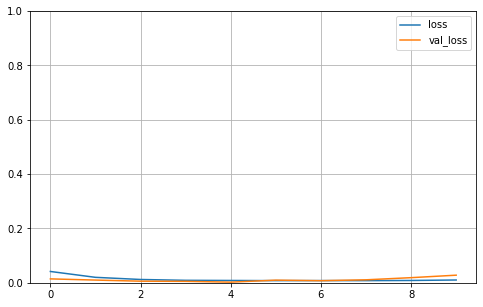

In [146]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [148]:
model.evaluate(x_test_arr, y_test_arr)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0.02803217529669376

In [149]:
from keras.layers import SimpleRNN

In [152]:
model_2 = keras.models.Sequential([
keras.layers.SimpleRNN(20, return_sequences=True, input_shape=(x_train_arr.shape[1],14)),
keras.layers.SimpleRNN(20, return_sequences=True),
keras.layers.SimpleRNN(1)
])

In [154]:
opt = tf.keras.optimizers.Adam(lr=1e-3,decay=1e-5)

In [161]:
model_2.compile(loss="binary_crossentropy",optimizer=opt,metrics=['accuracy'])

In [164]:
history_2 = model_2.fit(x_train_arr,y_train_arr,epochs=10,validation_data=(x_test_arr,y_test_arr))

Train on 520680 samples, validate on 130170 samples
Epoch 1/10
520680/520680 [==============================] - 43s 83us/sample - loss: 0.1234 - accuracy: 0.9668 - val_loss: 0.0944 - val_accuracy: 0.9704
Epoch 2/10
520680/520680 [==============================] - 51s 98us/sample - loss: 0.1153 - accuracy: 0.9709 - val_loss: 0.0731 - val_accuracy: 0.9744
Epoch 3/10
520680/520680 [==============================] - 53s 102us/sample - loss: 0.0926 - accuracy: 0.9740 - val_loss: 0.0669 - val_accuracy: 0.9744
Epoch 4/10
520680/520680 [==============================] - 52s 100us/sample - loss: 0.0764 - accuracy: 0.9759 - val_loss: 0.1002 - val_accuracy: 0.9856
Epoch 5/10
520680/520680 [==============================] - 55s 106us/sample - loss: 0.0831 - accuracy: 0.9765 - val_loss: 0.0702 - val_accuracy: 0.9547
Epoch 6/10
520680/520680 [==============================] - 55s 106us/sample - loss: 0.0798 - accuracy: 0.9767 - val_loss: 0.0722 - val_accuracy: 0.9851
Epoch 7/10
520680/520680 [======

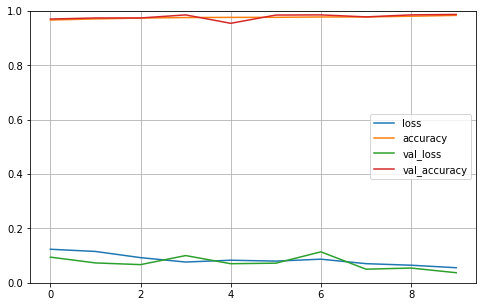

In [165]:
pd.DataFrame(history_2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [166]:
model_3 = keras.models.Sequential([
keras.layers.GRU(20, return_sequences=True, input_shape=(x_train_arr.shape[1],14)),
keras.layers.GRU(20, return_sequences=True),
keras.layers.GRU(1)
])

In [167]:
model_3.compile(loss="binary_crossentropy",optimizer=opt,metrics=['accuracy'])

In [169]:
history_3 = model_3.fit(x_train_arr,y_train_arr,epochs=10,validation_data=(x_test_arr,y_test_arr))

Train on 520680 samples, validate on 130170 samples
Epoch 1/10
520680/520680 [==============================] - 111s 214us/sample - loss: 0.0784 - accuracy: 0.9691 - val_loss: 0.0474 - val_accuracy: 0.9822
Epoch 2/10
520680/520680 [==============================] - 101s 194us/sample - loss: 0.0446 - accuracy: 0.9839 - val_loss: 0.0427 - val_accuracy: 0.9818
Epoch 3/10
520680/520680 [==============================] - 98s 188us/sample - loss: 0.0399 - accuracy: 0.9855 - val_loss: 0.0338 - val_accuracy: 0.9888
Epoch 4/10
520680/520680 [==============================] - 101s 193us/sample - loss: 0.0375 - accuracy: 0.9866 - val_loss: 0.0332 - val_accuracy: 0.9871
Epoch 5/10
520680/520680 [==============================] - 100s 192us/sample - loss: 0.0379 - accuracy: 0.9862 - val_loss: 0.0501 - val_accuracy: 0.9793
Epoch 6/10
520680/520680 [==============================] - 98s 189us/sample - loss: 0.0354 - accuracy: 0.9872 - val_loss: 0.0309 - val_accuracy: 0.9890
Epoch 7/10
520680/520680 [

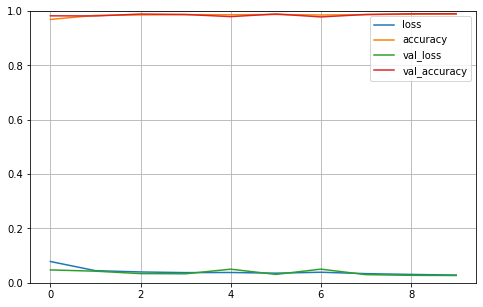

In [170]:
pd.DataFrame(history_3.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [171]:
model_3.evaluate(x_test_arr, y_test_arr)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[0.026846352747467002, 0.99003613]